## Exploratory Data Analysis
#### In this notebook I ask the question: What is important in fantasy football? By investigating the data we can see trends that indicate fantasy value. We can look at the age distribution of NFL players, the importance of quarterbacks that run the football, and the PPR format upside for running backs who are receiving threats out of the backfield

#### Importing packages and reading data frame created in Data Cleaning notebook

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
FFBD_tot = pd.read_csv('../Fantasyfb_Data/FFBD_tot.csv')

#### Creating Data Frames for Each Position
##### This is so we can investigate common trends among all players as well as look at how certain statistics affect different positions. For example, we wouldn't need to consider receiving yards when looking at quarterbacks.

In [8]:
FFBD_tot = FFBD_tot.rename(columns={'Att (Rush)':'Att_Rush',
                          'Att (Pass)':'Att_Pass',
                          'Yds (Pass)':'Yds_Pass',
                          'Total Snaps': 'Total_Snaps',
                          'Yds (Rec)': 'Yds_Rec',
                          'PPR (Rec)': 'Tot_PPR_Rec',
                          'PPR (Rush)': 'PPR_Rush',
                          'Y/R': 'Yds_per_rec'})
dropcolumnsQBs = ['FantPos',
    'Tgt',
    'Rec',
    'Yds_Rec',
    'Yds_per_rec',
    'TD (Rec)',
    'PPR_Tgt',
    'Tot_PPR_Rec',
    'PPR_Rec']
dropcolumnsOther = ['FantPos',
    'Y/A (Pass)',
    'PPR (Pass)',
    'Cmp',
    'Att_Pass',
    'Yds_Pass',
    'TD (Pass)',
    'Int',
    'Passer_Rating']
QBs = FFBD_tot[FFBD_tot['FantPos'] == 'QB'].drop(columns=dropcolumnsQBs)
RBs = FFBD_tot[FFBD_tot['FantPos'] == 'RB'].drop(columns=dropcolumnsOther)
WRs = FFBD_tot[FFBD_tot['FantPos'] == 'WR'].drop(columns=dropcolumnsOther)
TEs = FFBD_tot[FFBD_tot['FantPos'] == 'TE'].drop(columns=dropcolumnsOther)

##### Distribution of Player Age by Position: Note that these age distributions are exclusively for the 2024 season. As expected, quarterbacks tend to skew older while running backs and wide receivers are generally younger players. This can inform draft strategy by raising questions about players who are over 30 at RB and WR.

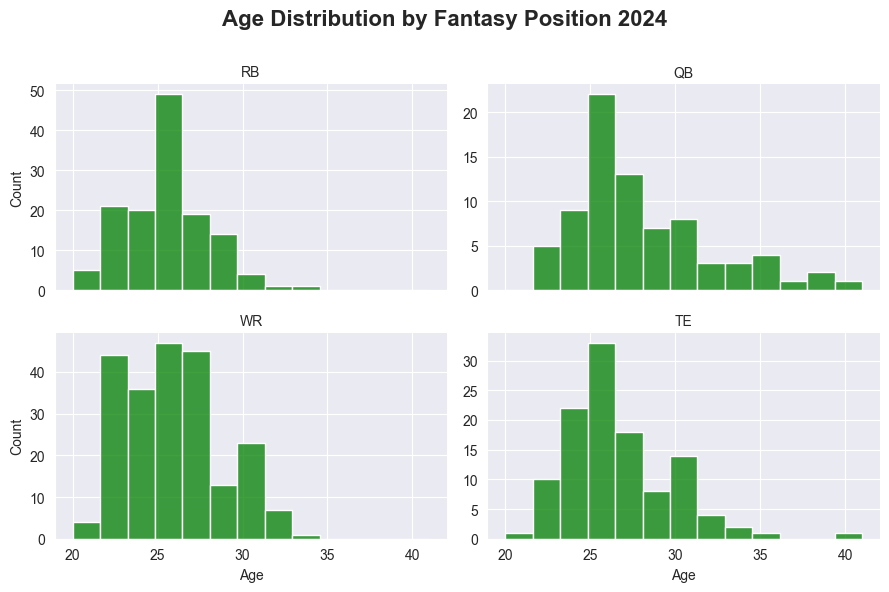

In [9]:
FFBD_2024 = FFBD_tot[FFBD_tot['Year'] == 2024]
sns.set_style('darkgrid')
g = sns.displot(
    data=FFBD_2024,
    x="Age",
    col="FantPos",
    col_wrap=2,
    bins=13,
    color="green",
    facet_kws={"sharex": True, "sharey": False},
    height=3,
    aspect=1.5
)

g.set_axis_labels("Age", "Count")
g.set_titles("{col_name}")
g.figure.suptitle("Age Distribution by Fantasy Position 2024", fontsize=16, fontweight='bold')
g.figure.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


##### Average PPR Scored per Snap by Position: When evaluating which positions to priortize in drafts, it's important to consider how many spots your league allocates for each. Since quarterbacks tend to score the most fantasy points, they should be priortized in leagues with two or more quarterback strating slots. If your league has just one starting slot, consider filling out the rest of your roster before selecting a quarterback.

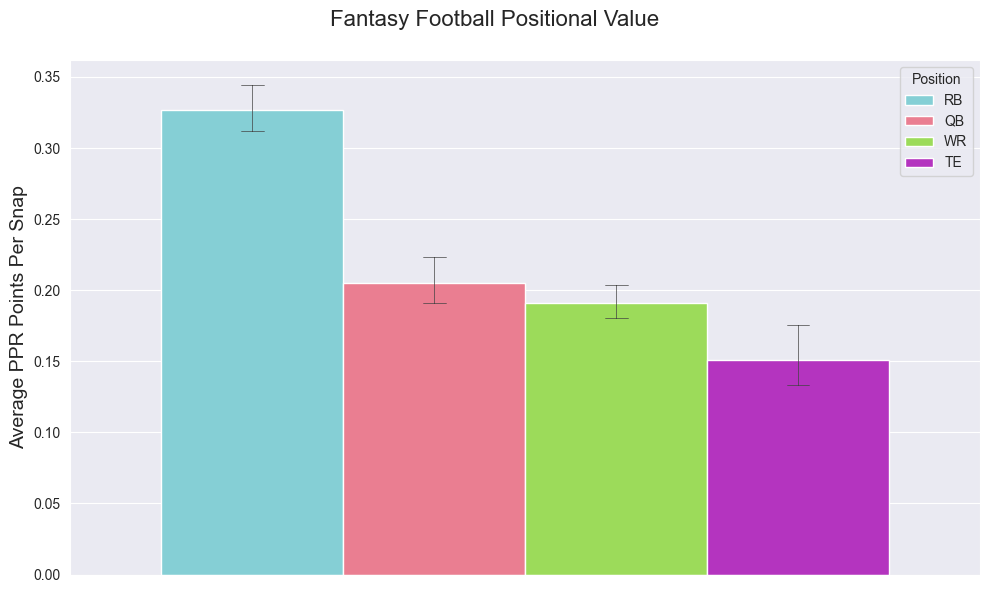

In [10]:
palette = ['#78DBE2', '#FC6C85', "#9DF045", "#C71DD6"]
plt.figure(figsize=(10,6))
b = sns.barplot(
    data=FFBD_tot,
    y='PPR_Snap',
    hue='FantPos',
    palette=palette,
    estimator='mean',
    legend='brief',
    capsize=0.1,
    err_kws={'linewidth':0.5}
)
b.set_ylabel('Average PPR Points Per Snap', fontsize = 14)
b.figure.suptitle('Fantasy Football Positional Value', fontsize = 16)
b.legend(title='Position')
plt.tight_layout(rect =[0,0,1,0.98])
plt.show()

#### Running Quarterback are Good for Fantasy:
##### A simple least squares model can show us the value of quarterbacks who have rushing upside. According to the model below, for every QB rush attempt there is a 0.77 PPR point increase. 

In [15]:
import statsmodels.formula.api as smf

In [7]:
QB_reg = smf.ols('PPR ~ Att_Rush + Att_Pass + Yds_Pass + TD + Total_Snaps', data=QBs).fit()
print(QB_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     6413.
Date:                Fri, 29 Aug 2025   Prob (F-statistic):               0.00
Time:                        14:32:34   Log-Likelihood:                -2579.5
No. Observations:                 614   AIC:                             5171.
Df Residuals:                     608   BIC:                             5198.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.4220      0.999     -4.429      

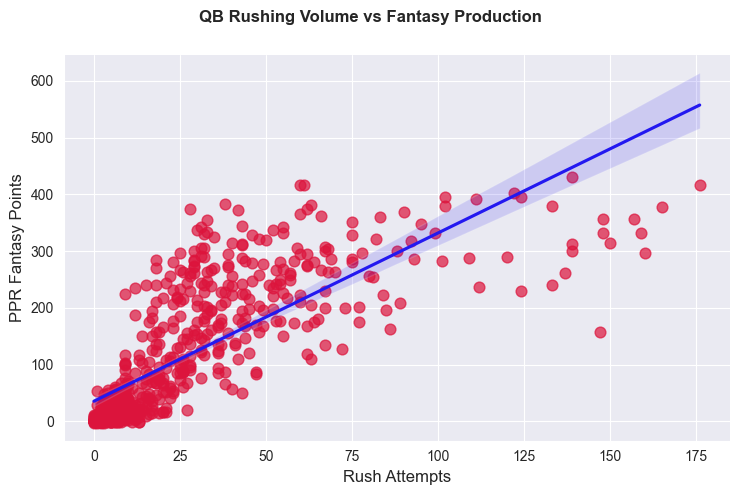

In [8]:
regplot = sns.lmplot(data=QBs,
                     x='Att_Rush',
                     y='PPR',
                     fit_reg=True,
                     aspect=1.5,
                     height=5,
                     scatter_kws={'s': 60,
                                  'color':'crimson',
                                  'alpha': 0.7,
                                  'marker': 'o'
                                 },
                     line_kws={'color':"#2318F0"})
regplot.set_axis_labels('Rush Attempts', 'PPR Fantasy Points', fontsize=12)
regplot.figure.suptitle('QB Rushing Volume vs Fantasy Production', fontweight='bold')
regplot.figure.tight_layout(rect=[0,0,1,0.98])
plt.show()

#### QB Efficiency: Passing, Rushing, Touchdowns
##### By filtering the larger data set by the top 2024 QBs we can plot their efficiency over time. We can use the efficiency metrics created at the end of the data cleaning notebook as well as creating a touchdown efficiency stat by dividing the number of total touchdowns by the total number of snaps. In general, the plots show that Lamar Jackson scores the most PPR points per pass, Josh Allen scores the most PPR points per rush, and Jalen Hurts has the highest percentage of rushes resulting in touchdowns (likely do to the Eagles' use of the tush push play)

In [36]:
mask = pd.notna(QBs['TD']) & (QBs['TD'] !=0) & pd.notna(QBs['Total_Snaps']) & (QBs['Total_Snaps'] !=0)
QBs.loc[mask, 'TD_Pct'] = (QBs.loc[mask, 'TD'] / QBs.loc[mask, 'Total_Snaps']) * 100

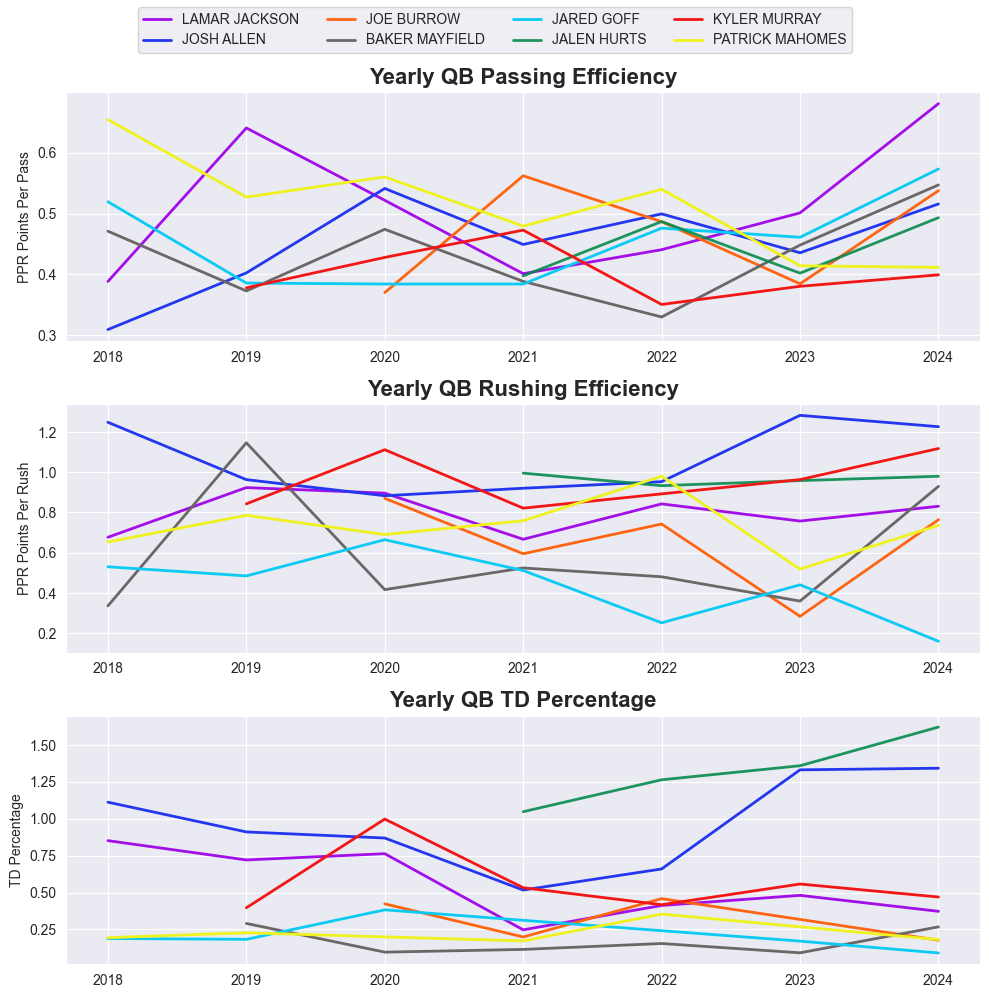

In [37]:
QBs_2024 = QBs[QBs['Year'] == 2024]
QB_Efficiency = QBs_2024.nlargest(10, 'PPR')
Relevant_QBs_2025 = ['LAMAR JACKSON',
                        'JOSH ALLEN',
                        'JOE BURROW',
                        'BAKER MAYFIELD',
                        'JARED GOFF',
                        'JALEN HURTS',
                        'PATRICK MAHOMES',
                        'KYLER MURRAY']
QBs_to_plot = QBs.loc[QBs['Player'].isin(Relevant_QBs_2025)]
QBs_to_plot = QBs_to_plot[QBs_to_plot['Year'] != 2017]
QBs_to_plot = QBs_to_plot[QBs_to_plot['Total_Snaps'] > 27]
custom_palette = ["#A30FE8",
                  "#2338EE",
                  "#FD6513",
                  "#6B6767",
                  "#0BCAF4",
                  "#02894CE1",
                  "#F31616",
                  "#EFF31D",
                  ]
custom_hue = ["#F0C919",
              "#020B89"]
fig, ax = plt.subplots(3,1,figsize=(10,10))
sns.lineplot(data=QBs_to_plot,
                 x='Year',
                 y='PPR_PassAtt',
                 hue='Player',
                 palette=custom_palette,
                 linewidth=2,
                 ax=ax[0])
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend_.remove()
ax[0].set_title('Yearly QB Passing Efficiency', fontweight='bold', fontsize=16)
ax[0].set_ylabel('PPR Points Per Pass')
ax[0].set_xlabel('')

sns.lineplot(data=QBs_to_plot,
                 x='Year',
                 y='PPR_RushAtt',
                 hue='Player',
                 palette=custom_palette,
                 linewidth=2,
                 ax=ax[1],
                 legend=False)
ax[1].set_title('Yearly QB Rushing Efficiency', fontweight='bold', fontsize=16)
ax[1].set_ylabel('PPR Points Per Rush')
ax[1].set_xlabel('')

sns.lineplot(data=QBs_to_plot,
                 x='Year',
                 y='TD_Pct',
                 hue='Player',
                 palette=custom_palette,
                 linewidth=2,
                 ax=ax[2],
                 legend=False)
ax[2].set_title('Yearly QB TD Percentage', fontweight='bold', fontsize=16)
ax[2].set_ylabel('TD Percentage')
ax[2].set_xlabel('')
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4,fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### How Important is Receiving for Running Backs?
##### For this section I show the distribution of PPR points scored across fifteen quantiles for both targets in the passing game as well as rush attempts. In doing so we can see roughly how a similar volume of targets translates to rushing volume. There is a general trend here of across these quantiles of running backs scoring more PPR points for volume through the passing game. As shown by the scatter plot, targets lead to more PPR points that rush attempts. This makes intuitive sense with a catch gauranteeing at least one point scored while a rushing attempt may result in just three or four yards – just 0.3 or 0.4 PPR points.

In [11]:
RBs['Tgt_Binned'] = pd.cut(RBs['Tgt'], bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150])
RBs['Att_Rush_Binned'] = pd.cut(RBs['Att_Rush'], bins=[0,26,52,78,104,130,156,182,208,234,260,286,312,338,364,390])

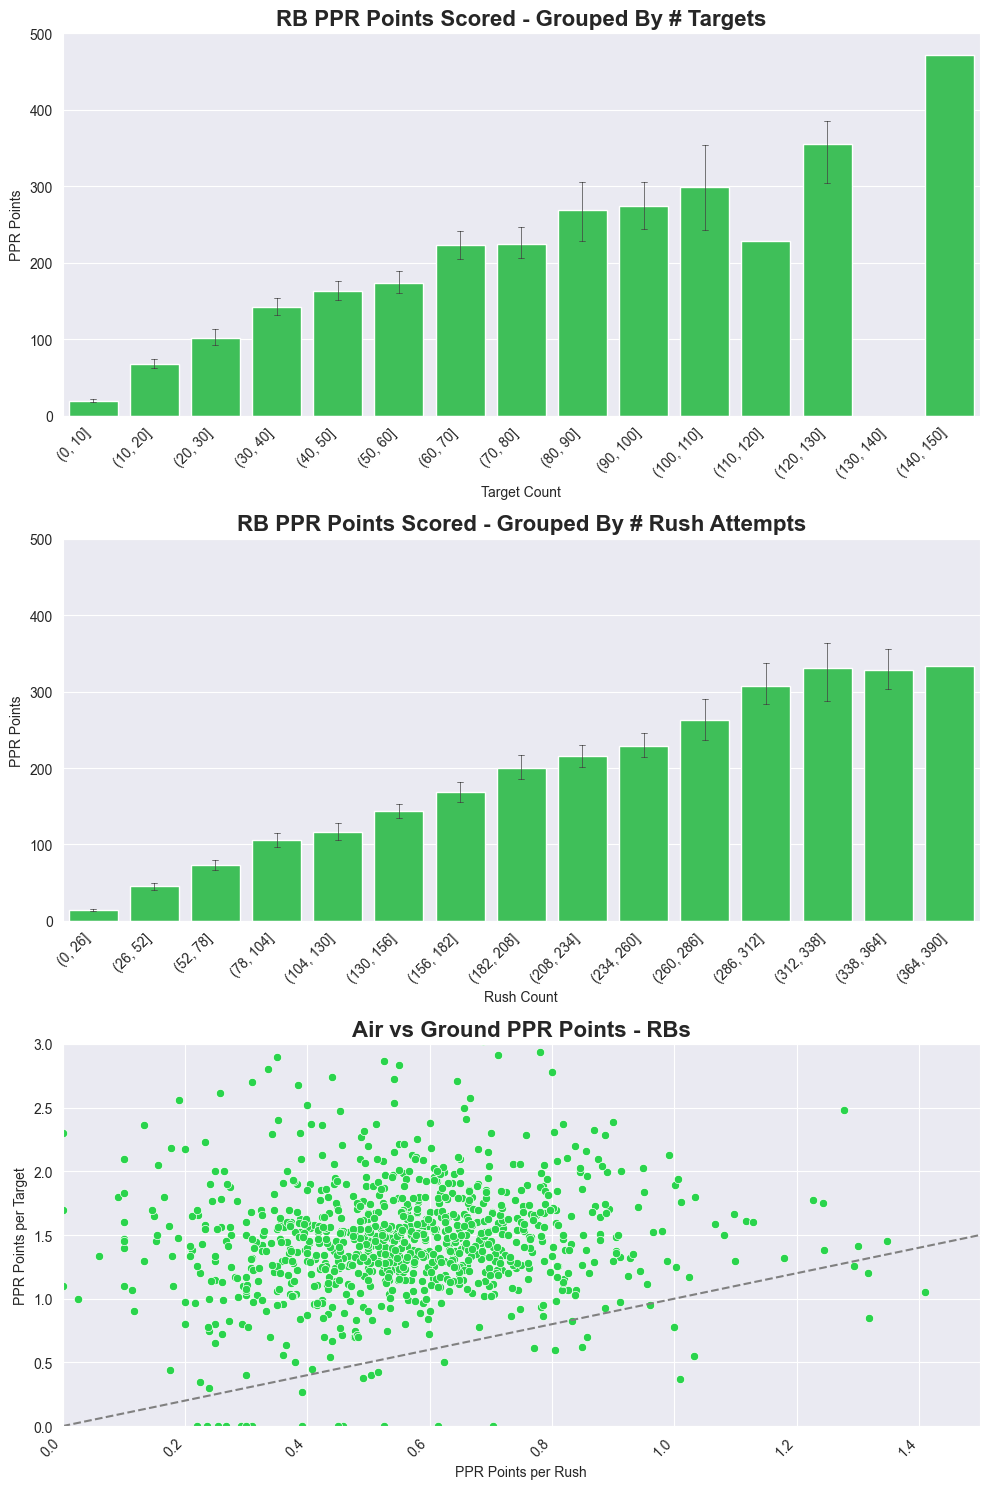

In [12]:
fig, ax = plt.subplots(3,1,figsize=(10,15))
sns.barplot(RBs,
            x='Tgt_Binned',
            y='PPR',
            estimator='mean',
            capsize=0.1,
            err_kws={'linewidth':0.5},
            color="#2AD44C",
            ax=ax[0]
            )
ax[0].set_title('RB PPR Points Scored - Grouped By # Targets', fontweight='bold', fontsize=16)
ax[0].set_xlabel('Target Count')
ax[0].set_ylabel('PPR Points')
ax[0].set_ybound(0,500)
sns.barplot(RBs,
            x='Att_Rush_Binned',
            y='PPR',
            estimator='mean',
            capsize=0.1,
            err_kws={'linewidth':0.5},
            color="#2AD44C",
            ax=ax[1]
            )
ax[1].set_title('RB PPR Points Scored - Grouped By # Rush Attempts', fontweight='bold', fontsize=16)
ax[1].set_xlabel('Rush Count')
ax[1].set_ylabel('PPR Points')
ax[1].set_ybound(0,500)
for a in ax:
    for label in a.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

sns.scatterplot(
    data=RBs,
    x='PPR_RushAtt',
    y='PPR_Tgt',
    color = "#2AD44C",
    ax=ax[2]
)
ax[2].set_title('Air vs Ground PPR Points - RBs', fontsize=16,fontweight='bold')
ax[2].set_xlabel('PPR Points per Rush')
ax[2].set_ylabel('PPR Points per Target')
ax[2].axline((0,0), slope=1, color='gray', ls='--')
ax[2].set_ylim(0,3)
ax[2].set_xlim(0,1.5)
plt.tight_layout()
plt.show()

#### Rushing vs Receiving Leaders for Running Backs:
##### Here we can see that there are only two running backs landing in the top ten in touches through the air and on the ground. Those two running backs are Jahmyr Gibbs and Bijan Robinson. As we'll later see in the XGBoost model predictions, these two backs are in the top three highest 2025 predicted PPR points along with De'von Achane – the RB receiving leader.

In [38]:
RBs_2024 = RBs[RBs['Year'] == 2024]
Top_RBs_Ground_2024 = RBs_2024.sort_values('PPR_Rush', ascending=False).head(10)
Top_RBs_Air_2024 = RBs_2024.sort_values('Tot_PPR_Rec', ascending=False).head(10)

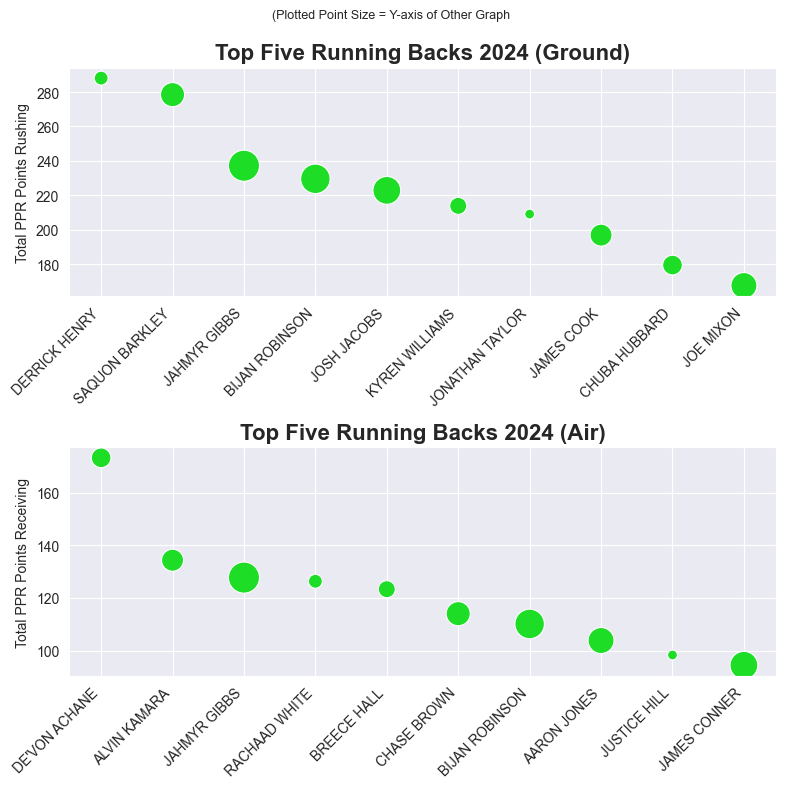

In [ ]:
sizes = [50,100,150,200,250,300,350,400,450,500]
fig, ax = plt.subplots(2,1, figsize=(8,8))
sns.scatterplot(
    Top_RBs_Ground_2024,
    x='Player',
    y='PPR_Rush',
    size='Tot_PPR_Rec',
    sizes=sizes,
    color="#1EDD27",
    s=150,
    legend=False,
    ax=ax[0]
)

ax[0].set_title('Top Five Running Backs 2024 (Ground)', fontsize=16, fontweight='bold')
ax[0].set_xlabel('')
ax[0].set_ylabel('Total PPR Points Rushing')


sns.scatterplot(
    Top_RBs_Air_2024,
    x='Player',
    y='Tot_PPR_Rec',
    size='PPR_Rush',
    sizes=sizes,
    color="#1EDD27",
    legend=False,
    ax=ax[1]
)

ax[1].set_title('Top Five Running Backs 2024 (Air)', fontsize=16, fontweight='bold')
ax[1].set_xlabel('')
ax[1].set_ylabel('Total PPR Points Receiving')
for a in ax:
    for label in a.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
plt.suptitle('(Point Size = Y-axis of Other Graph)', fontsize=9)
plt.tight_layout(rect=[0,0,1,0.99])
plt.show()

#### Which is more important for Wide Receivers: Total Catches or Total Yards?
##### I initially hypothesized that there would be certain receivers that scored a lot of points catching short passes. This would have led to a greater ratio of points from catching the ball to yards gained from the catch. However, the pie graph tells us that the opposite is true. While still relatively even, yards gained accounts for more fantasy points for wide receivers even in PPR formats.

In [11]:
WRs['PPR_Yards_Only'] = WRs['Yds_Rec'] * 0.1

In [12]:
sizes=[(WRs['Rec'].sum()),(WRs['PPR_Yards_Only'].sum())]

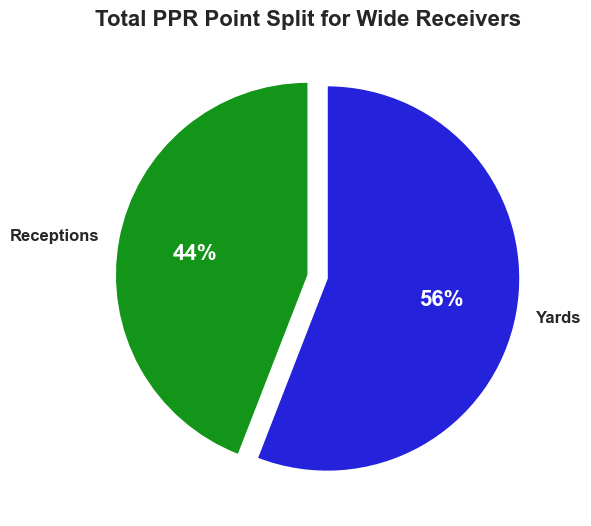

In [13]:
pie_colors=['#139519',"#2522DC"]
fig, ax = plt.subplots(figsize=(6,6))
wedges, text, autotexts = ax.pie(
    sizes,
    labels=['Receptions', 'Yards'],
    colors=pie_colors,
    explode=[0,0.1],
    startangle=90,
    autopct = ('%1.0f%%')
)
for t in text:
    t.set_fontsize(12),
    t.set_fontweight('bold')

for t in autotexts:
    t.set_fontsize(16)
    t.set_fontweight('bold')
    t.set_color('white')
ax.set_title("Total PPR Point Split for Wide Receivers", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### The Effect of Yards per Reception on WR PPR Production
##### To investigate the above finding further, I use another simple least squares model to predict how many PPR points for receivers is due to yardage rather than catches. Interestingly enough, the model shows that my initial hypothesis is true. For every yard per reception, PPR points increase by 0.67. This means that there is some nuance when considering which of these stats is more valuable. It's possible that there are many receivers who do not get a lot of playing time skewing this OLS finding toward receptions being more valuable, since receivers score more through yardage overall as shown by the pie graph above.

In [20]:
WR_reg = smf.ols('PPR ~ Yds_per_rec + Rec + Tgt + TD + Total_Snaps', data=WRs).fit()
print(WR_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 3.709e+04
Date:                Wed, 03 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:30:07   Log-Likelihood:                -5840.1
No. Observations:                1682   AIC:                         1.169e+04
Df Residuals:                    1676   BIC:                         1.172e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -9.1244      0.560    -16.308      

#### WRs Leaders: PPR/Tgt 2024
##### Here we can see the fantasy leaders at the wide receiver position as well as their target efficiency. One receiver that stands out to me here is Terry McLaurin. He has similar efficiency with his targets as Ja'marr Chase. If you have reason to believe McLaurin will get more targets next season, it's possible that he could finish closer to the top three wide receivers.

In [22]:
WRs_2024 = WRs[(WRs['Year'] == 2024)]
Top_WRs_2024 = WRs_2024.sort_values('PPR', ascending=False).head(15)

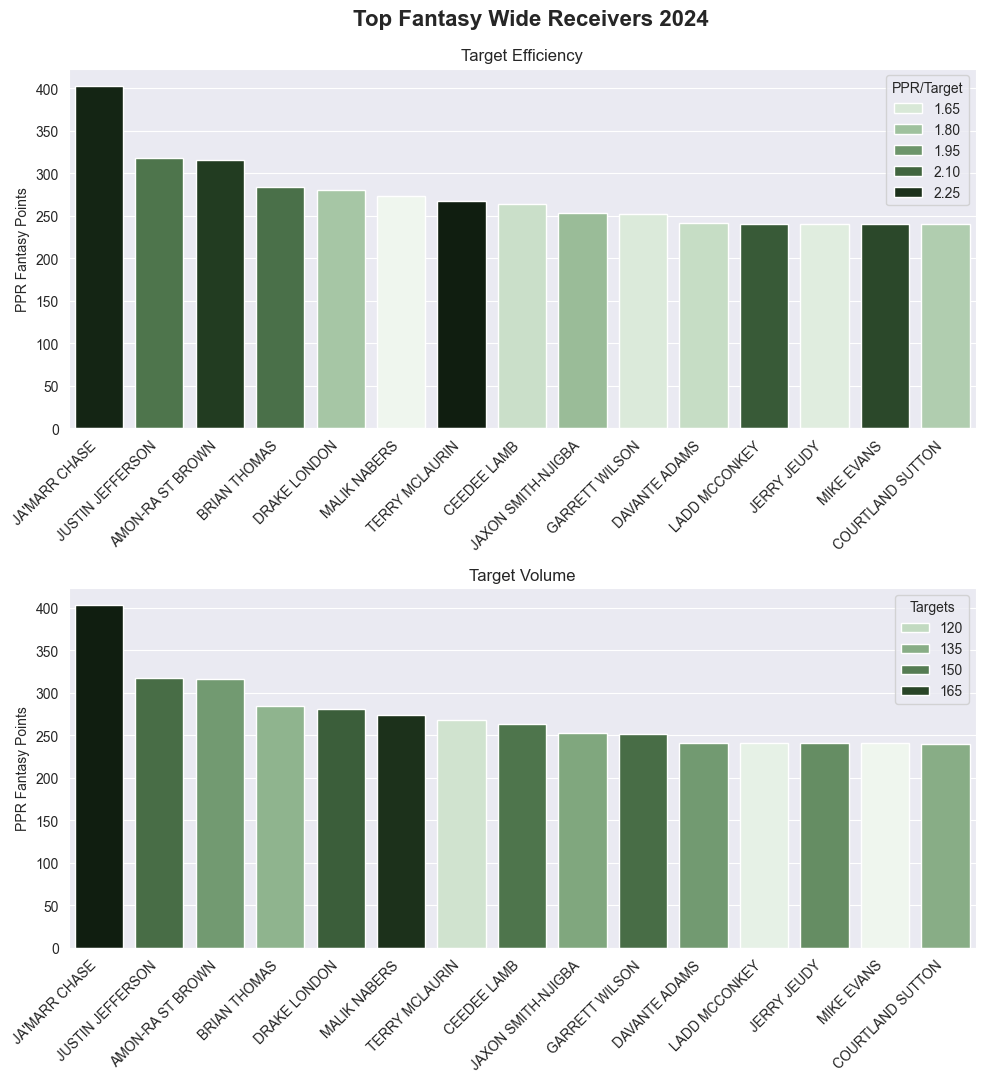

In [23]:
Palette = sns.cubehelix_palette(start=1.9, rot=0, dark=0.1, light=.95, reverse=False, as_cmap=True)
fig, ax = plt.subplots(2,1, figsize=(10,11))
w1 = sns.barplot(
    Top_WRs_2024,
    x='Player',
    y='PPR',
    hue='PPR_Tgt',
    orient='x',
    palette=Palette,
    ax=ax[0]
)
w2 = sns.barplot(
    Top_WRs_2024,
    x='Player',
    y='PPR',
    hue='Tgt',
    orient='x',
    palette=Palette,
    ax=ax[1]
)
for b in ax:
    for label in b.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
w1.set_xlabel('')
w1.set_ylabel('PPR Fantasy Points')
w1.set_title('Target Efficiency')
w1.legend(title='PPR/Target',fontsize=10)
w2.set_xlabel('')
w2.set_ylabel('PPR Fantasy Points')
w2.set_title('Target Volume')
w2.legend(title='Targets',fontsize=10)
plt.suptitle('Top Fantasy Wide Receivers 2024', x=0.54, fontsize=16, fontweight = 'bold')
plt.tight_layout(rect=[0,0,1,0.99])
plt.show()

#### Distribution of Target Effiency and Volume WRs 2024
##### As theorized earlier, there is a large volume of receivers with only a few targets. If these targets go for ten yards or less, they could be skewing the effect of yards per reception downward in the OLS model. We can also see that there is a normal distribution of wide receiver efficiency, with the largest quantile scoring between 1.5 and 2.0 PPR points per target.

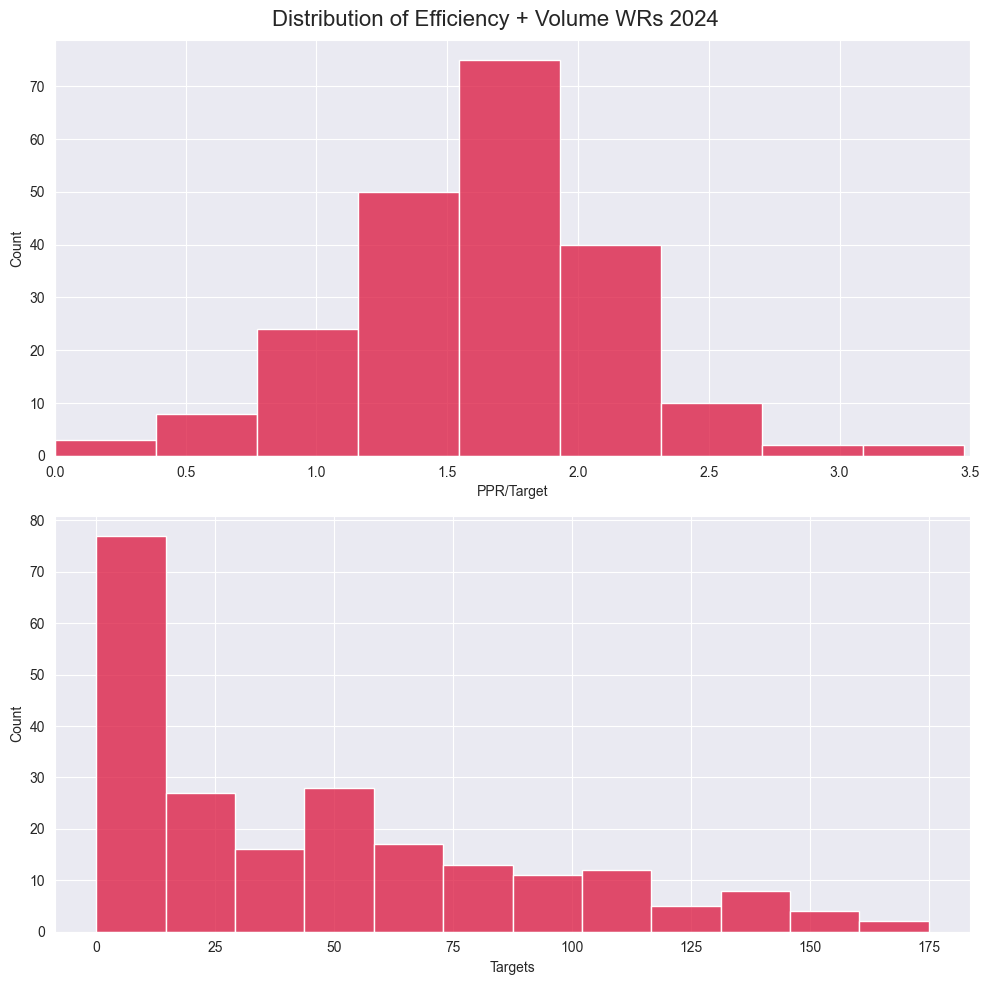

In [24]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
w3 = sns.histplot(
    data=WRs_2024,
    x="PPR_Tgt",
    bins=36,
    color="crimson",
    ax=ax[0]
)
w4 = sns.histplot(
    data=WRs_2024,
    x="Tgt",
    bins=12,
    color="crimson",
    ax=ax[1]
)
w3.set_xlim(0,3.5)
w3.set_xlabel('PPR/Target')
w4.set_xlabel('Targets')
plt.suptitle('Distribution of Efficiency + Volume WRs 2024', fontsize=16)
plt.tight_layout()
plt.show()

#### TEs Leaders: PPR/Tgt 2024
##### Here we are applying the same visualization for 2024 wide receiver fantasy points to the tight end position. The one player that really stands out to me is Mark Andrews. It wasn't very long ago that Andrews was a top three fantasy tight end, but with backup tight end Isiah Likely getting more targets in 2024, Andrews' overall production decreased. If the Ravens go back to featuring Andrews in a larger role, look for him to return to the top three fantasy tight end conversation.

In [27]:
TEs_2024 = TEs[(TEs['Year'] == 2024)]
Top_TEs_2024 = TEs_2024.sort_values('PPR', ascending=False).head(15)

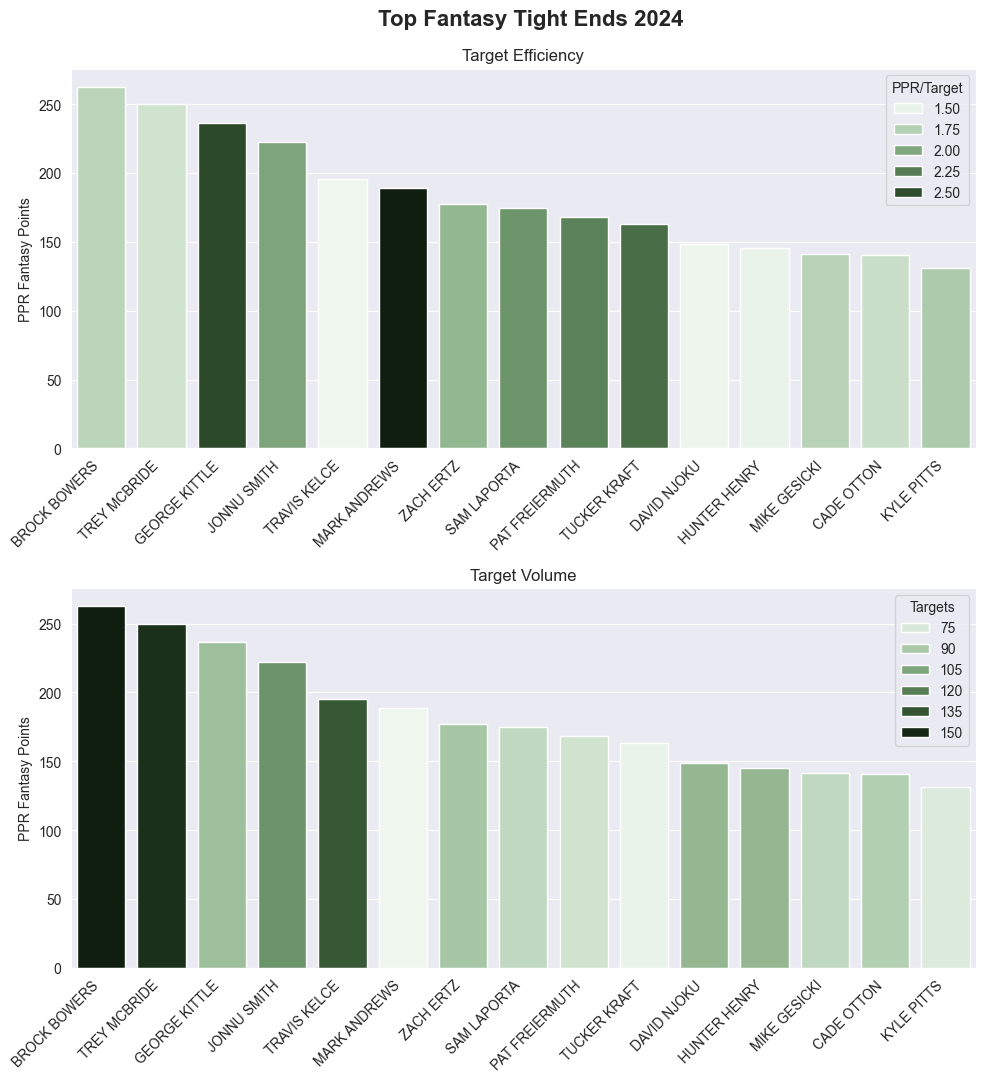

In [28]:
fig, ax = plt.subplots(2,1, figsize=(10,11))
T1 = sns.barplot(
    Top_TEs_2024,
    x='Player',
    y='PPR',
    hue='PPR_Tgt',
    orient='x',
    palette=Palette,
    ax=ax[0]
)
T2 = sns.barplot(
    Top_TEs_2024,
    x='Player',
    y='PPR',
    hue='Tgt',
    orient='x',
    palette=Palette,
    ax=ax[1]
)
for b in ax:
    for label in b.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
T1.set_xlabel('')
T1.set_ylabel('PPR Fantasy Points')
T1.set_title('Target Efficiency')
T1.legend(title='PPR/Target',fontsize=10)
T2.set_xlabel('')
T2.set_ylabel('PPR Fantasy Points')
T2.set_title('Target Volume')
T2.legend(title='Targets',fontsize=10)
plt.suptitle('Top Fantasy Tight Ends 2024', x=0.54, fontsize=16, fontweight = 'bold')
plt.tight_layout(rect=[0,0,1,0.99])
plt.show()

#### Distribution of Target Effiency and Volume TEs 2024
##### The distribution shows that there were only a few tight ends targeted over 100 times in 2024. A quick filter shows us that there are only four of them: Bowers, McBride, Smith, and Kelce. Similarly to receivers, the distribution of efficiency is clustered around the 1.0 to 2.0 range.

In [29]:
Top_TE_Tgt = TEs_2024[TEs_2024['Tgt'] > 100]
Top_TE_Tgt

,Player,Tm,Age,G,GS,Att_Rush,Yds (Rush),Y/A,TD (Rush),Tgt,...,TM SNAP %,PPR_PassAtt,PPR_Rush,PPR_RushAtt,Tot_PPR_Rec,PPR_Tgt,Tgt_gm,PPR_Rec,PPR_Snap,Year
19,BROCK BOWERS,LVR,22.0,17.0,16.0,5.0,13.0,2.6,0.0,153.0,...,85.1,NaN,1.3,0.26,261.4,1.708497,9.000000,2.333929,0.274791,2024
23,TREY MCBRIDE,ARI,25.0,16.0,16.0,1.0,2.0,2.0,1.0,147.0,...,85.2,NaN,6.2,6.20,237.6,1.616327,9.187500,2.140541,0.267452,2024
27,JONNU SMITH,MIA,29.0,17.0,6.0,2.0,-1.0,-0.5,0.0,111.0,...,55.0,NaN,-0.1,-0.05,224.4,2.021622,6.529412,2.550000,0.355112,2024
58,TRAVIS KELCE,KAN,35.0,16.0,16.0,1.0,1.0,1.0,0.0,133.0,...,81.9,NaN,0.1,0.10,197.3,1.483459,8.312500,2.034021,0.207872,2024


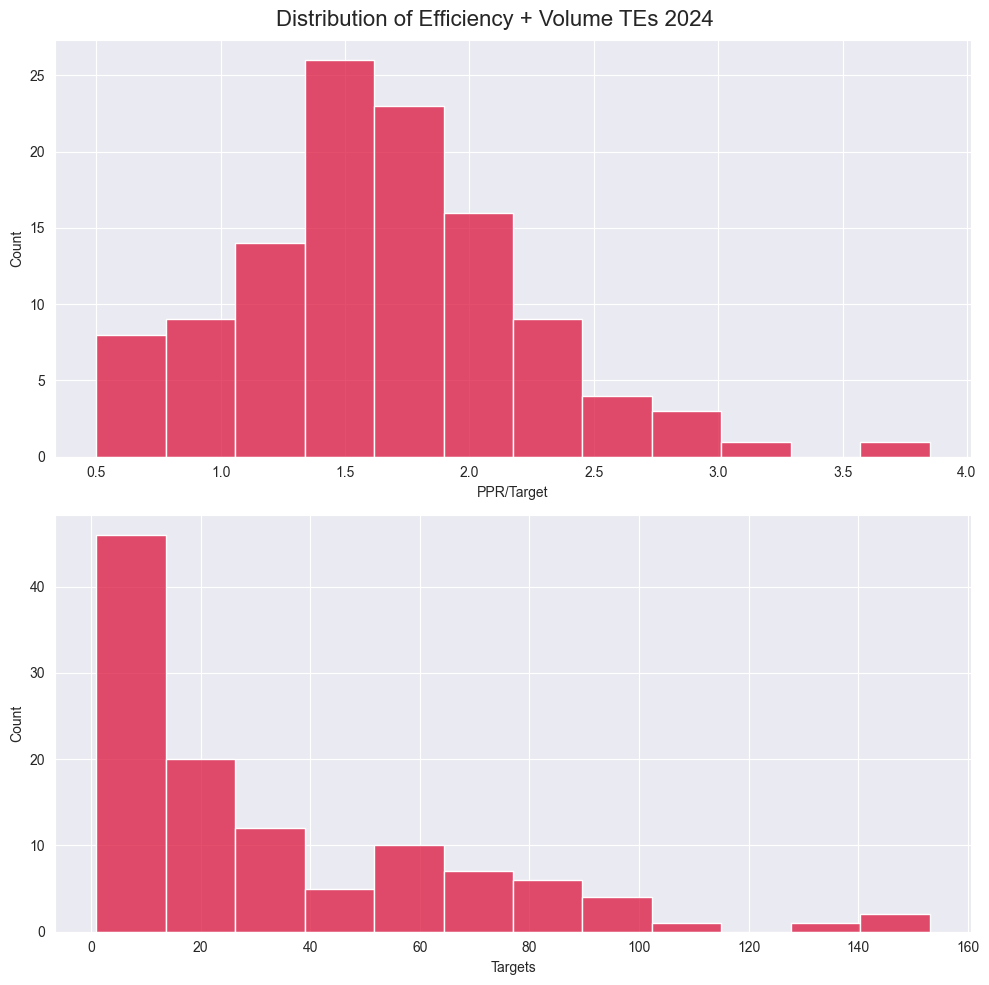

In [26]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
T3 = sns.histplot(
    data=TEs_2024,
    x="PPR_Tgt",
    bins=12,
    color="crimson",
    ax=ax[0]
)
T4 = sns.histplot(
    data=TEs_2024,
    x="Tgt",
    bins=12,
    color="crimson",
    ax=ax[1]
)
T3.set_xlabel('PPR/Target')
T4.set_xlabel('Targets')
plt.suptitle('Distribution of Efficiency + Volume TEs 2024', fontsize=16)
plt.tight_layout()
plt.show()

#### What Positions Tend to Have the Best Fantasy Finishes?
##### We already investigated which positions are most valuable in fantasy football and found that quarterbacks tend to score the most points each season, but that doesn't necessarily mean that quarterbacks finish with the top spots each year. However, when filtering the data by the top PPR finishes, we once again see that quarterbacks account for the majority of top finishes. However, it must be noted that the two best fantasy finishes since 2017 were produced by a running back and a wide receiver. Additionally, the pie graph shows that quarterbacks account for 54% of the top 50 fantasy finishes since 2017.

In [30]:
FFBD_tot.sort_values('PPR', ascending=False)

,Player,Tm,FantPos,Age,G,GS,Cmp,Att_Pass,Yds_Pass,TD (Pass),...,Y/A (Pass),PPR_Rush,PPR_RushAtt,Tot_PPR_Rec,PPR_Tgt,Tgt_gm,PPR_Rec,PPR_Snap,Passer_Rating,Year
2765,CHRISTIAN MCCAFFREY,CAR,RB,23.0,16.0,16.0,0.0,2.0,0.0,0.0,...,0.000000,228.7,0.796864,240.5,1.693662,8.875000,2.073276,0.453513,39.583333,2019
1639,COOPER KUPP,LAR,WR,28.0,17.0,17.0,0.0,1.0,0.0,0.0,...,0.000000,1.8,0.450000,435.7,2.281152,11.235294,3.004828,0.429199,39.583333,2021
3,LAMAR JACKSON,BAL,QB,27.0,17.0,17.0,316.0,474.0,4172.0,41.0,...,8.801688,115.5,0.830935,0.0,NaN,NaN,NaN,0.400745,106.010900,2024
1075,PATRICK MAHOMES,KAN,QB,27.0,17.0,17.0,435.0,648.0,5250.0,41.0,...,8.101852,59.8,0.980328,1.6,1.600000,0.058824,1.600000,0.369054,94.088220,2022
3282,PATRICK MAHOMES,KAN,QB,23.0,16.0,16.0,383.0,580.0,5097.0,50.0,...,8.787931,39.2,0.653333,0.0,NaN,NaN,NaN,0.403385,100.783046,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764,KENDALL HINTON,DEN,WR,23.0,1.0,0.0,1.0,9.0,13.0,0.0,...,1.444444,0.7,0.350000,0.0,NaN,NaN,NaN,-0.116667,0.000000,2020
1637,TIM BOYLE,CHI,QB,28.0,1.0,0.0,2.0,8.0,33.0,0.0,...,4.125000,-0.2,-0.100000,0.0,NaN,NaN,NaN,-0.223077,39.583333,2022
2211,JOSH ROSEN,ATL,QB,24.0,4.0,0.0,2.0,11.0,19.0,0.0,...,1.727273,0.0,NaN,0.0,NaN,NaN,NaN,-0.123077,0.000000,2021
2212,DIONTAE SPENCER,DEN,WR,29.0,15.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,0.7,0.175000,0.266667,0.700000,-0.061111,NaN,2021


In [27]:
Top_Players = FFBD_tot.sort_values('PPR', ascending=False).head(50)
for_pie = Top_Players.groupby('FantPos').count()
sizes2 = [27,14,9]
labels2 = ['QBs', 'RBs', 'WRs']

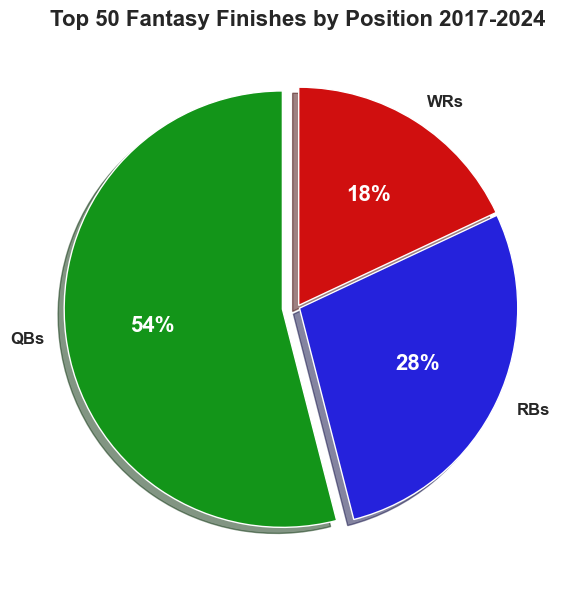

In [28]:
pie_colors2=['#139519',"#2522DC", "#D00F0F", "#E7D91E"]
fig, ax = plt.subplots(figsize=(6,6))
wedges, text, autotexts = ax.pie(
    sizes2,
    labels=labels2,
    colors=pie_colors2,
    explode=[0.07,0.01,0.01],
    startangle=90,
    autopct = ('%1.0f%%'),
    shadow=True
)
for c in text:
    c.set_fontsize(12),
    c.set_fontweight('bold')

for c in autotexts:
    c.set_fontsize(16)
    c.set_fontweight('bold')
    c.set_color('white')
ax.set_title("Top 50 Fantasy Finishes by Position 2017-2024", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### Best Offenses for PPR Production
##### Here I plot every team's total fantasy points scored for 2024. A quick glance at the top teams shows us that playoff teams and high powered offenses score the most fantasy points overall e.g. Tampa, Detroit, Baltimore. A team that finished on the outside looking in last season was the Cincinnati Bengals, but according to the bar plot, they actually scored the third most overall fantasy points. Since they didn't make many additions to their defense this season, look for them to have to put up a lot of points again in 2025.

In [29]:
Temp = FFBD_2024[(FFBD_2024['Tm'] != '2TM') & (FFBD_2024['Tm'] != '3TM')]

Tm_PPR_2024 = Temp.groupby('Tm')['PPR'].sum()
Tm_PPR_2024.index = Tm_PPR_2024.index.str.strip()

In [30]:
nfl_colors = {
    "ARI": "#97233F",
    "ATL": "#A71930",
    "BAL": "#241773",
    "BUF": "#00338D",
    "CAR": "#0085CA",
    "CHI": "#0B162A",
    "CIN": "#FB4F14",
    "CLE": "#311D00",
    "DAL": "#003594",
    "DEN": "#FB4F14",
    "DET": "#0076B6",
    "GNB": "#203731",
    "HOU": "#03202F",
    "IND": "#002C5F",
    "JAX": "#006778",
    "KAN": "#E31837",
    "LAC": "#0080C6",
    "LAR": "#003594",
    "LVR": "#000000",
    "MIA": "#008E97",
    "MIN": "#4F2683",
    "NWE": "#002244",
    "NOR": "#D3BC8D",
    "NYG": "#0B2265",
    "NYJ": "#125740",
    "PHI": "#004C54",
    "PIT": "#FFB612",
    "SFO": "#AA0000",
    "SEA": "#002244",
    "TAM": "#D50A0A",
    "TEN": "#4B92DB",
    "WAS": "#5A1414",
}

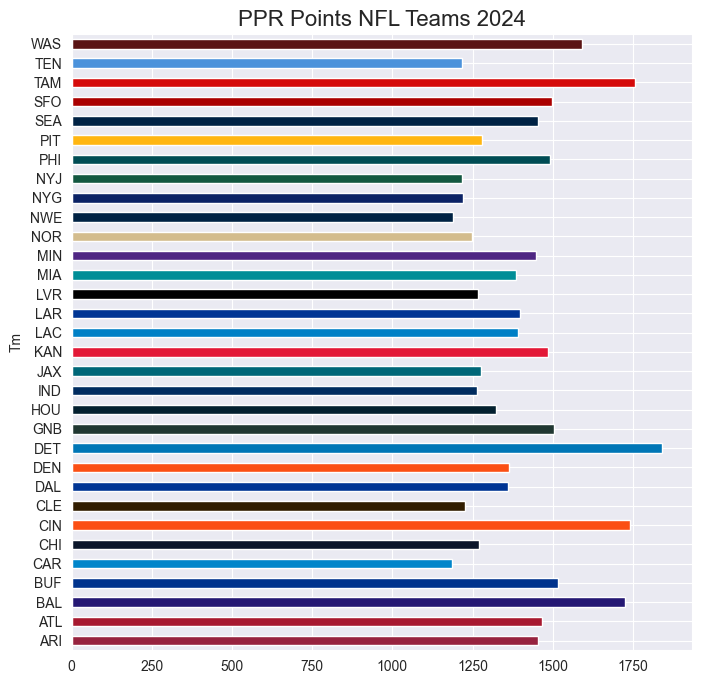

In [31]:
colors1 = [nfl_colors[Team] for Team in Tm_PPR_2024.index]
Tm_PPR_2024.plot(kind='barh', color=colors1, figsize=(8,8))
plt.title('PPR Points NFL Teams 2024', fontsize=16)
plt.show()

##### Exporting positional data frames to be used in forecasting notebook

In [32]:
QBs.to_csv('/Users/alexanderlarson/Desktop/Python Projects/Fantasy Football Rankings/Fantasyfb_Data/QBs.csv')
RBs.to_csv('/Users/alexanderlarson/Desktop/Python Projects/Fantasy Football Rankings/Fantasyfb_Data/RBs.csv')
WRs.to_csv('/Users/alexanderlarson/Desktop/Python Projects/Fantasy Football Rankings/Fantasyfb_Data/WRs.csv')
TEs.to_csv('/Users/alexanderlarson/Desktop/Python Projects/Fantasy Football Rankings/Fantasyfb_Data/TEs.csv')